# Vehicle Detection

## Import Libraries

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pickle
from skimage.feature import hog
import cv2
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Utility Functions

In [2]:
def figure(figsize, gssize):
    """
    Creates figure using the provided figure size and gridspec size. 
    """
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    gs = gridspec.GridSpec(*gssize)
    return fig, gs

def imshow(image, gs, title=None, cmap=None, show_axis=False):
    """
    Shows the provided image onto the gridspec.
    """
    plt.subplot(gs)
    plt.imshow(image, cmap=cmap)
    if title is not None: plt.title(title)
    if not show_axis:
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

## Read Raw Dataset

In [3]:
BASE_DIR = './data'

In [4]:
vehicle_folder_pattern = glob.glob(BASE_DIR + '/vehicles/*')
non_vehicle_folder_pattern = glob.glob(BASE_DIR + '/non-vehicles/*')

vehicle_files = []
for folder in vehicle_folder_pattern:
    vehicle_files.extend(glob.glob('{}/*.png'.format(folder)))

non_vehicle_files = []
for folder in non_vehicle_folder_pattern:
    non_vehicle_files.extend(glob.glob('{}/*.png'.format(folder)))

print('total vehicles: {}'.format(len(vehicle_files)))
print('total non vehicles: {}'.format(len(non_vehicle_files)))

total vehicles: 8792
total non vehicles: 8968


In [5]:
RAW_DATA_FILE = BASE_DIR + '/raw_data.p'
if os.path.exists(RAW_DATA_FILE):
    with open(RAW_DATA_FILE, 'rb') as f:
        pickle_data = pickle.load(f)
        vehicles = pickle_data['vehicles']
        non_vehicles = pickle_data['non_vehicles']
else:
    vehicles = np.array([cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in vehicle_files])
    non_vehicles = np.array([cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in non_vehicle_files])
    
    pickle_data = {
        'vehicles': vehicles,
        'non_vehicles': non_vehicles
    }
    with open(RAW_DATA_FILE, 'wb') as f:
        pickle.dump(pickle_data, f)

n_vehicles = len(vehicles)
n_non_vehicles = len(non_vehicles)

## Visualize the Dataset

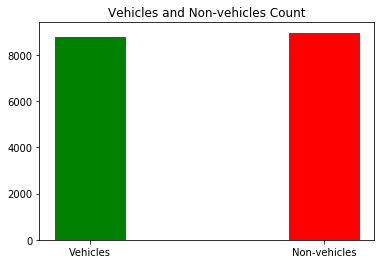

In [6]:
bars = plt.bar([0, 1], [len(vehicle_files), len(non_vehicle_files)], width=0.3)
bars[0].set_color('g')
bars[1].set_color('r')
plt.xticks([0, 1], ['Vehicles', 'Non-vehicles'])
plt.title('Vehicles and Non-vehicles Count')

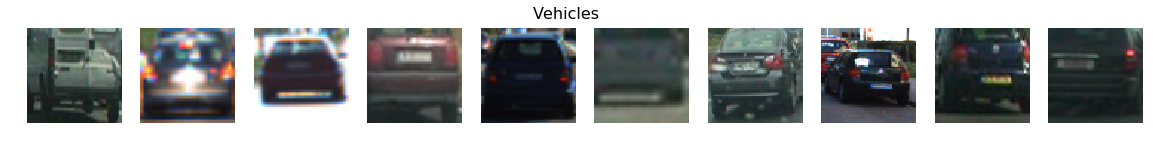

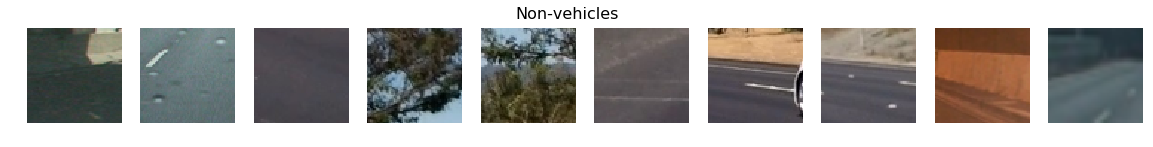

In [7]:
rand_idxes = np.random.choice(n_vehicles, 10, replace=False)
rand_images = vehicles[rand_idxes, :, :, :]
plt.figure(figsize=(20, 2))
for i, image in enumerate(rand_images):
    plt.subplot(1, 10, i+1)
    plt.imshow(image)
    plt.suptitle('Vehicles', fontsize=16)
    plt.axis('off')
    
rand_idxes = np.random.choice(n_non_vehicles, 10, replace=False)
rand_images = non_vehicles[rand_idxes, :, :, :]
plt.figure(figsize=(20, 2))
for i, image in enumerate(rand_images):
    plt.subplot(1, 10, i+1)
    plt.imshow(image)
    plt.suptitle('Non-vehicles', fontsize=16)
    plt.axis('off')

In [8]:
def convert_color(image, color_space='RGB'):
    """
    Convert the image to the specified color space.
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if color_space == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        if color_space == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: image = np.copy(image)
    
    return image

### Plot the Spatial Features

In [9]:
def get_spatial_features(image, size):
    return cv2.resize(image, size).ravel()

In [10]:
rand_vehicle = vehicles[np.random.randint(n_vehicles)]
rand_non_vehicle = non_vehicles[np.random.randint(n_non_vehicles)]

<Container object of 768 artists>

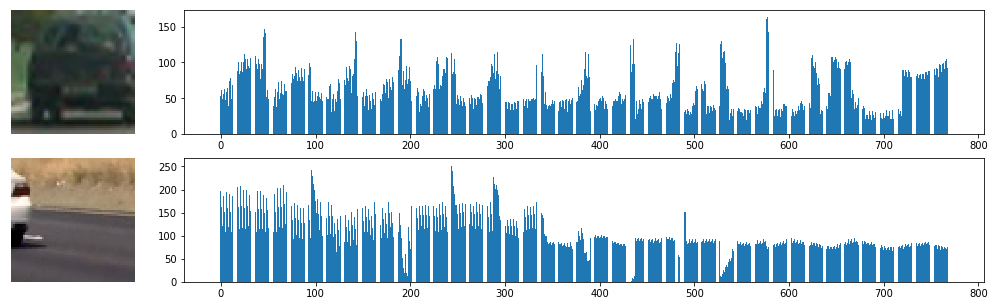

In [11]:
fig, gs = figure(figsize=(18, 5), gssize=(2, 5))

imshow(rand_vehicle, gs[0, 0])
plt.subplot(gs[0, 1:])
spatial_features = get_spatial_features(rand_vehicle, size=(16, 16))
plt.bar(np.arange(len(spatial_features)), spatial_features)

imshow(rand_non_vehicle, gs[1, 0])
plt.subplot(gs[1, 1:])
spatial_features = get_spatial_features(rand_non_vehicle, size=(16, 16))
plt.bar(np.arange(len(spatial_features)), spatial_features)

### Plot the Color Histogram Features

In [12]:
def get_hist_features(image, nbins, bins_range=(0, 256)):
    hist = np.histogram(image, bins=nbins, range=bins_range)
    return hist[0]

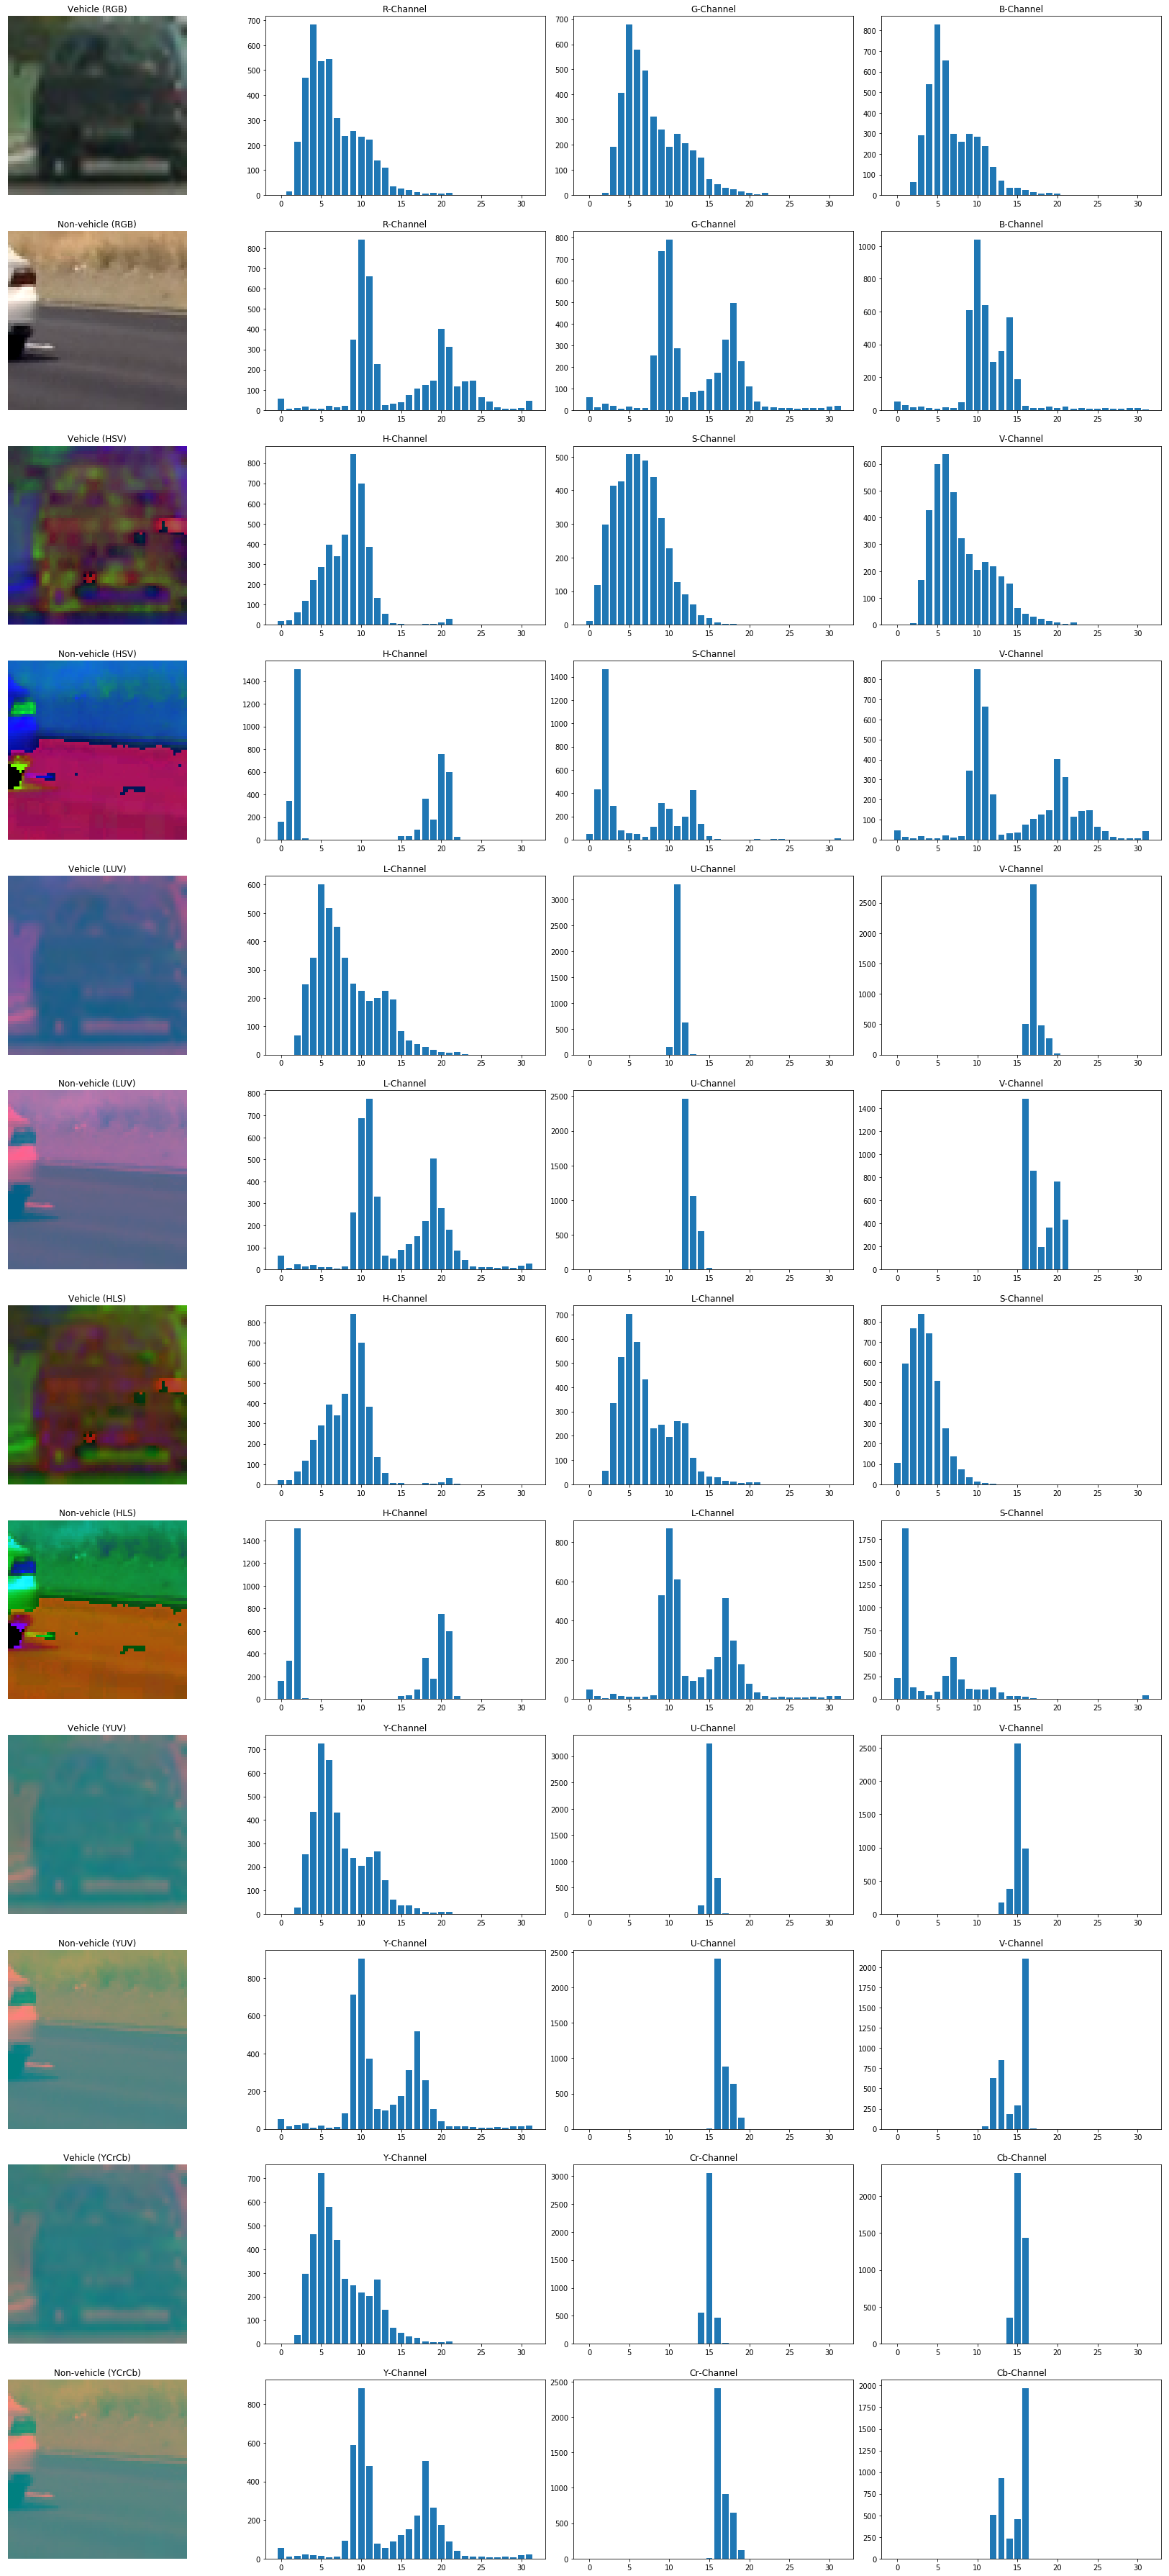

In [13]:
fig, gs = figure(figsize=(30, 65), gssize=(12, 4))

for i, color_space in enumerate(['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']):
    for j in range(2):
        if j == 0:
            temp_image = convert_color(rand_vehicle, color_space)
            imshow(temp_image, gs[2*i+j, 0], title='Vehicle ({})'.format(color_space))
        else:
            temp_image = convert_color(rand_non_vehicle, color_space)
            imshow(temp_image, gs[2*i+j, 0], title='Non-vehicle ({})'.format(color_space))
        
        plt.subplot(gs[2*i+j, 1])
        plt.bar(np.arange(32), get_hist_features(temp_image[:, :, 0], nbins=32))
        plt.title('{}-Channel'.format(color_space[0]))
    
        plt.subplot(gs[2*i+j, 2])
        plt.bar(np.arange(32), get_hist_features(temp_image[:, :, 1], nbins=32))
        if color_space != 'YCrCb':
            plt.title('{}-Channel'.format(color_space[1]))
        else:
            plt.title('{}-Channel'.format(color_space[1:3]))
        
        plt.subplot(gs[2*i+j, 3])
        plt.bar(np.arange(32), get_hist_features(temp_image[:, :, 2], nbins=32))
        if color_space != 'YCrCb':
            plt.title('{}-Channel'.format(color_space[2]))
        else:
            plt.title('{}-Channel'.format(color_space[3:]))

### Plot the HOG Features

In [14]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=True):
    if visualise:
        features, hog_image = hog(image,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  visualise=True,
                                  feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(image,
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm='L2-Hys',
                       visualise=False,
                       feature_vector=feature_vec)
        return features

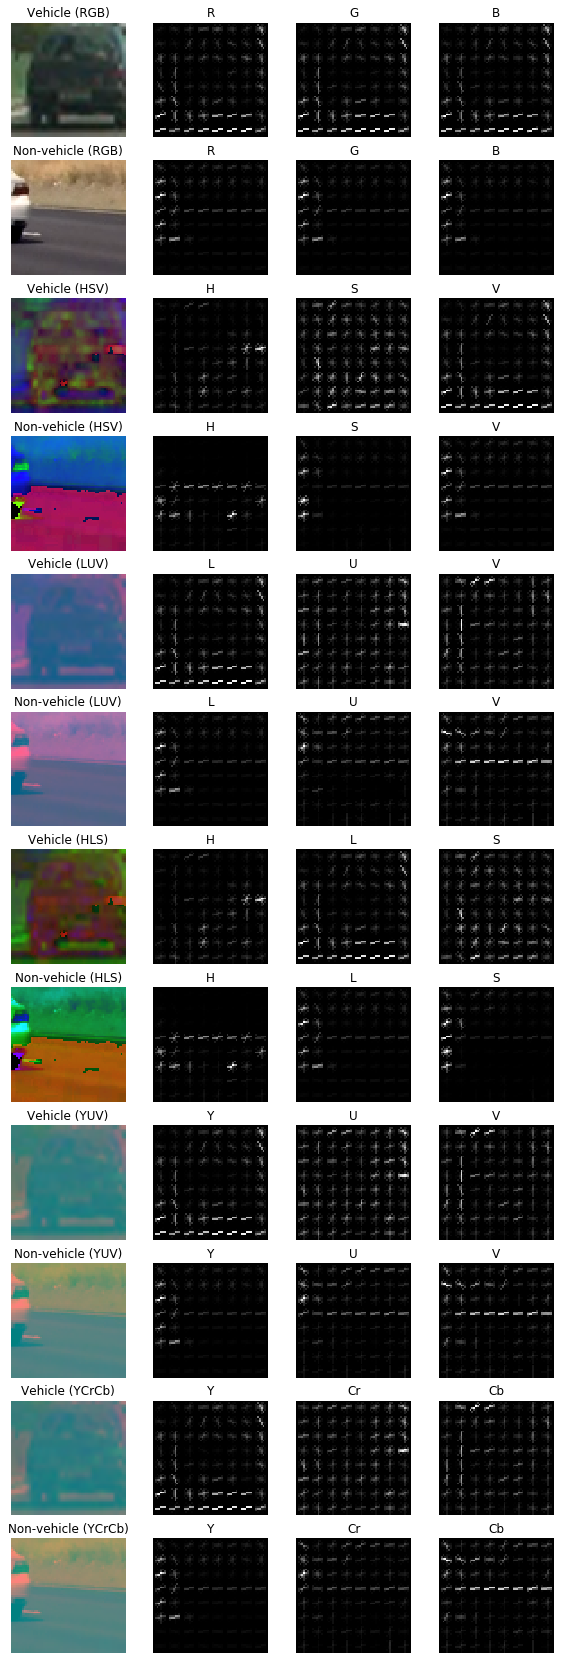

In [15]:
fig, gs = figure(figsize=(10, 30), gssize=(12, 4))

for i, color_space in enumerate(['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']):
    for j in range(2):
        if j == 0:
            temp_image = convert_color(rand_vehicle, color_space)
            imshow(temp_image, gs[2*i+j, 0], title='Vehicle ({})'.format(color_space))
        else:
            temp_image = convert_color(rand_non_vehicle, color_space)
            imshow(temp_image, gs[2*i+j, 0], title='Non-vehicle ({})'.format(color_space))
        
        for k in range(3):
            hog_features, hog_image = get_hog_features(temp_image[:, :, k], orient=9, pix_per_cell=8, cell_per_block=3, visualise=True)
            if color_space != 'YCrCb':
                title = color_space[k]
            else:
                title = ['Y', 'Cr', 'Cb'][k]
            imshow(hog_image, gs[2*i+j, k+1], title=title, cmap='gray')

## Training Classifer

In [16]:
def extract_features(image, params):
    """
    Extracts features of the image using the giving parameters.
    """
    color_space = params['color_space']
    spatial_enabled = params['spatial_enabled']
    spatial_size = params['spatial_size']
    color_hist_enabled = params['color_hist_enabled']
    color_hist_bins = params['color_hist_bins']
    color_hist_channels = params['color_hist_channels']
    hog_enabled = params['hog_enabled']
    hog_channels = params['hog_channels']
    hog_orientations = params['hog_orientations']
    hog_pix_per_cell = params['hog_pix_per_cell']
    hog_cell_per_block = params['hog_cell_per_block']
    
    assert color_space in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'], 'Wrong color space {}'.format(color_space)
    
    image = convert_color(image, color_space)
    #image = image.astype(np.float32) / 255 # Do not need to normalize here, I was troubled by this problem for many days.
    
    features = []
        
    if spatial_enabled:
        features.append(get_spatial_features(image, size=spatial_size))
    if color_hist_enabled:
        hist_features = []
        for ch in color_hist_channels:
            hist_features.append(get_hist_features(image[:, :, ch], nbins=color_hist_bins))
        features.append(np.concatenate(hist_features))
    if hog_enabled:
        hog_features = []
        for ch in hog_channels:
            hog_features.append(get_hog_features(image[:, :, ch],
                                                 orient=hog_orientations,
                                                 pix_per_cell=hog_pix_per_cell,
                                                 cell_per_block=hog_cell_per_block,
                                                 visualise=False, feature_vec=True))
        features.append(np.concatenate(hog_features))
        
    return np.concatenate(features)

In [17]:
def generate_train_test_data(vehicles, non_vehicles, params):
    """
    Generate training and test dataset.
    """
    vehicle_features = [extract_features(image, params) for image in vehicles]
    non_vehicle_features = [extract_features(image, params) for image in non_vehicles]
    features = np.vstack([vehicle_features, non_vehicle_features]).astype(np.float64)
    
    scaler = StandardScaler().fit(features)
    scaled_features = scaler.transform(features)
    
    labels = np.hstack([np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))])
    
    rand_state = np.random.randint(0, 100)
    features_train, features_test, labels_train, labels_test = train_test_split(
        scaled_features, labels, test_size=0.2, random_state=rand_state)
    return features_train, features_test, labels_train, labels_test, scaler

In [18]:
def train_classifier(features_train, labels_train):
    """
    Train a linear SVM classifier using the given features and labels.
    """
    clf = LinearSVC()
    clf.fit(features_train, labels_train)
    return clf

In [19]:
# Generates mini batch

np.random.shuffle(vehicles)
np.random.shuffle(non_vehicles)
mini_batch_vehicles = vehicles[:2000, :, :, :]
mini_batch_non_vehicles = non_vehicles[:2000, :, :, :]

In [20]:
def try_parameters(vehicles, non_vehicles, params):
    """
    Tries each combination of parameters and measures the result.
    """
    t0 = time.time()

    features_train, features_test, labels_train, labels_test, scaler = generate_train_test_data(
        vehicles, non_vehicles, params)
    t1 = time.time()
    print('Result:')
    print('\tdata generation time = {:.2f}s'.format(t1 - t0))
    print('\tfeature size = {}'.format(features_train.shape[1]))

    clf = train_classifier(features_train, labels_train)
    t2 = time.time()
    print('\ttrain time = {:.2f}s'.format(t2 - t1))

    score = clf.score(features_test, labels_test)
    t3 = time.time()
    print('\tscore = {:.4f}'.format(score))
    print('\tpredict time = {:.2f}s'.format(t3 - t2))
    
    print('\ttotal time = {:.2f}s'.format(t3 - t0))
    return clf, scaler

### Try Different Parameters

In [25]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': True,
    'spatial_size': (32, 32),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 43.19s
	feature size = 11916
	train time = 21.35s
	score = 0.9475
	predict time = 0.07s
	total time = 64.61s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [26]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 41.20s
	feature size = 9612
	train time = 15.16s
	score = 0.9537
	predict time = 0.01s
	total time = 56.37s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [27]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.12s
	feature size = 1836
	train time = 2.17s
	score = 0.9762
	predict time = 0.00s
	total time = 16.29s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [28]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 17.99s
	feature size = 1836
	train time = 2.23s
	score = 0.9700
	predict time = 0.01s
	total time = 20.24s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [29]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': True,
    'spatial_size': (8, 8),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.01s
	feature size = 1260
	train time = 1.17s
	score = 0.9812
	predict time = 0.00s
	total time = 15.19s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [30]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': False,
    'spatial_size': (16, 16),
    'color_hist_enabled': False,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.95s
	feature size = 972
	train time = 2.01s
	score = 0.9375
	predict time = 0.00s
	total time = 16.96s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [31]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': False,
    'spatial_size': (16, 16),
    'color_hist_enabled': False,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 44.62s
	feature size = 5292
	train time = 12.32s
	score = 0.9038
	predict time = 0.00s
	total time = 56.95s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [32]:
params = {
    'color_space': 'RGB',
    'spatial_enabled': False,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 18.03s
	feature size = 1068
	train time = 1.11s
	score = 0.9675
	predict time = 0.00s
	total time = 19.15s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [33]:
params = {
    'color_space': 'LUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 41.19s
	feature size = 9548
	train time = 1.69s
	score = 0.9838
	predict time = 0.01s
	total time = 42.89s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [34]:
params = {
    'color_space': 'LUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 13.04s
	feature size = 1772
	train time = 0.74s
	score = 0.9825
	predict time = 0.00s
	total time = 13.79s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [35]:
params = {
    'color_space': 'LUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 46.32s
	feature size = 6092
	train time = 1.05s
	score = 0.9725
	predict time = 0.01s
	total time = 47.38s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [36]:
params = {
    'color_space': 'LUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 17.83s
	feature size = 1836
	train time = 0.38s
	score = 0.9825
	predict time = 0.00s
	total time = 18.21s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [37]:
params = {
    'color_space': 'LUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.72s
	feature size = 1836
	train time = 0.46s
	score = 0.9850
	predict time = 0.00s
	total time = 15.18s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [38]:
params = {
    'color_space': 'YUV',
    'spatial_enabled': True,
    'spatial_size': (32, 32),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 39.57s
	feature size = 11852
	train time = 2.29s
	score = 0.9762
	predict time = 0.01s
	total time = 41.87s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [39]:
params = {
    'color_space': 'YUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 38.78s
	feature size = 9548
	train time = 1.96s
	score = 0.9812
	predict time = 0.01s
	total time = 40.75s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [40]:
params = {
    'color_space': 'YUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 12.17s
	feature size = 1772
	train time = 0.56s
	score = 0.9738
	predict time = 0.00s
	total time = 12.73s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [41]:
params = {
    'color_space': 'YUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 15.41s
	feature size = 1772
	train time = 0.52s
	score = 0.9775
	predict time = 0.00s
	total time = 15.93s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [42]:
params = {
    'color_space': 'YUV',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 3
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.14s
	feature size = 1836
	train time = 0.60s
	score = 0.9762
	predict time = 0.00s
	total time = 14.75s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [43]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, ),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 15.92s
	feature size = 1772
	train time = 0.47s
	score = 0.9775
	predict time = 0.00s
	total time = 16.39s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [44]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 48.06s
	feature size = 6156
	train time = 0.84s
	score = 0.9762
	predict time = 0.01s
	total time = 48.91s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [45]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 17.34s
	feature size = 1836
	train time = 0.53s
	score = 0.9800
	predict time = 0.00s
	total time = 17.87s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [46]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 12,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 18.00s
	feature size = 2160
	train time = 0.65s
	score = 0.9938
	predict time = 0.00s
	total time = 18.66s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [47]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 1
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 21.01s
	feature size = 1296
	train time = 1.26s
	score = 0.9725
	predict time = 0.00s
	total time = 22.27s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [48]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (32, 32),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 17.90s
	feature size = 4140
	train time = 1.89s
	score = 0.9825
	predict time = 0.01s
	total time = 19.80s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [49]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (32, 32),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 8,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 48.91s
	feature size = 8460
	train time = 1.75s
	score = 0.9775
	predict time = 0.01s
	total time = 50.67s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

In [50]:
params = {
    'color_space': 'YCrCb',
    'spatial_enabled': False,
    'spatial_size': (16, 16),
    'color_hist_enabled': False,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 9,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

try_parameters(mini_batch_vehicles, mini_batch_non_vehicles, params)

Result:
	data generation time = 14.54s
	feature size = 972
	train time = 0.96s
	score = 0.9487
	predict time = 0.00s
	total time = 15.50s


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

### The Final Parameters to Choose

In [51]:
final_params = {
    'color_space': 'YCrCb',
    'spatial_enabled': True,
    'spatial_size': (16, 16),
    'color_hist_enabled': True,
    'color_hist_bins': 32,
    'color_hist_channels': (0, 1, 2),
    'hog_enabled': True,
    'hog_channels': (0, 1, 2),
    'hog_orientations': 12,
    'hog_pix_per_cell': 16,
    'hog_cell_per_block': 2
}

clf, scaler = try_parameters(vehicles, non_vehicles, final_params)

Result:
	data generation time = 82.20s
	feature size = 2160
	train time = 4.56s
	score = 0.9890
	predict time = 0.01s
	total time = 86.77s


In [21]:
# Save the model

if os.path.exists(BASE_DIR + '/model.p'):
    with open(BASE_DIR + '/model.p', 'rb') as f:
        pickle_file = pickle.load(f)
        clf = pickle_file['classifier']
        scaler = pickle_file['scaler']
        final_params = pickle_file['parameters']
    print('Loaded from saved model.')
else:
    with open(BASE_DIR + '/model.p', 'wb') as f:
        pickle.dump({
            'classifier': clf,
            'scaler': scaler,
            'parameters': final_params
        }, f)
    print('Save model.')

Loaded from saved model.


## Sliding Window Search

In [22]:
def get_sliding_windows(image, x_range=(None, None), y_range=(None, None), window_size=(64, 64), overlap=(0.5, 0.5)):
    """
    Generates sliding windows.
    """
    x_range = (
        x_range[0] if x_range[0] is not None else 0,
        x_range[1] if x_range[1] is not None else image.shape[1]
    )
    y_range = (
        y_range[0] if y_range[0] is not None else 0,
        y_range[1] if y_range[1] is not None else image.shape[0]
    )
    
    x_span = x_range[1] - x_range[0]
    y_span = y_range[1] - y_range[0]
    
    nx_pix_per_step = np.int(window_size[0] * (1 - overlap[0]))
    ny_pix_per_step = np.int(window_size[1] * (1 - overlap[1]))
    
    nx_windows = np.int(x_span / nx_pix_per_step) - 1
    ny_windows = np.int(y_span / ny_pix_per_step) - 1
    
    sliding_windows = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            x_start = xs * nx_pix_per_step + x_range[0]
            x_end = x_start + window_size[0]
            y_start = ys * ny_pix_per_step + y_range[0]
            y_end = y_start + window_size[1]
            
            sliding_windows.append(((x_start, y_start), (x_end, y_end)))
            
    return sliding_windows

In [23]:
def draw_sliding_windows(image, windows, color=(255, 0, 0), thickness=6):
    """
    Draw sliding windows on image.
    """
    temp = np.copy(image)
    for w in windows:
        cv2.rectangle(temp, w[0], w[1], color, thickness)
    return temp

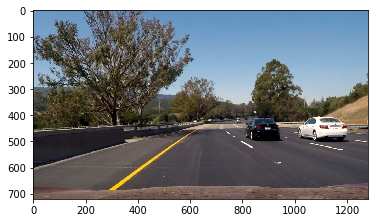

In [24]:
test_images = []
for file_name in glob.glob('./test_images/*.jpg'):
    test_images.append(cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB))
plt.imshow(test_images[0])

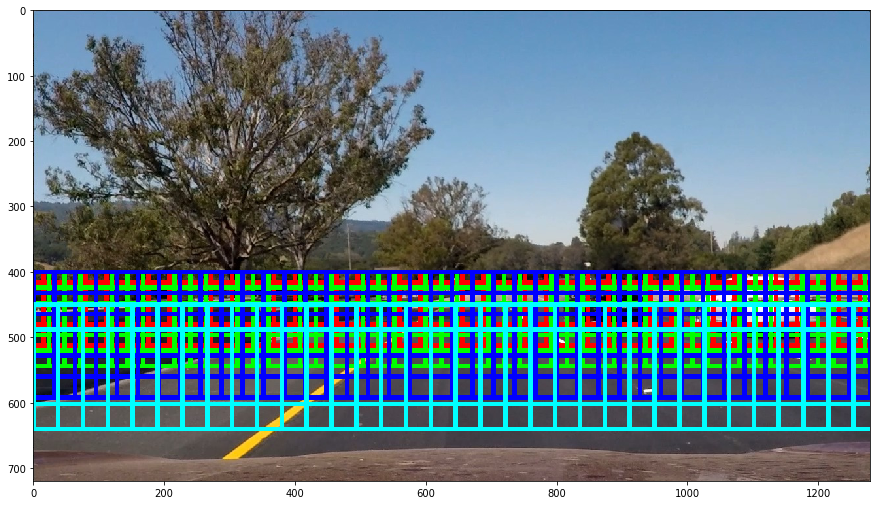

In [25]:
# Visualize slding windows.

temp = np.copy(test_images[0])
windows = get_sliding_windows(temp, y_range=(400, 500), window_size=(64, 64), overlap=(0.75, 0.75))
temp = draw_sliding_windows(temp, windows)

windows = get_sliding_windows(temp, y_range=(400, 500), window_size=(96, 96), overlap=(0.75, 0.75))
temp = draw_sliding_windows(temp, windows, color=(0, 255, 0))

windows = get_sliding_windows(temp, y_range=(400, 550), window_size=(128, 128), overlap=(0.75, 0.75))
temp = draw_sliding_windows(temp, windows, color=(0, 0, 255))

windows = get_sliding_windows(temp, y_range=(450, 600), window_size=(152, 152), overlap=(0.75, 0.75))
temp = draw_sliding_windows(temp, windows, color=(0, 255, 255))

plt.figure(figsize=(15, 15))
plt.imshow(temp)

In [26]:
def find_cars(image, windows, clf, scaler, parameters):
    """
    Finds cars in the sliding widows of the image.
    """
    result = []
    for window in windows:
        temp = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(temp, parameters)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        conf = clf.decision_function(test_features)
        if prediction == 1 and conf > 0.8:
            result.append(window)

    return result

CPU times: user 20.7 s, sys: 93.3 ms, total: 20.7 s
Wall time: 20.8 s


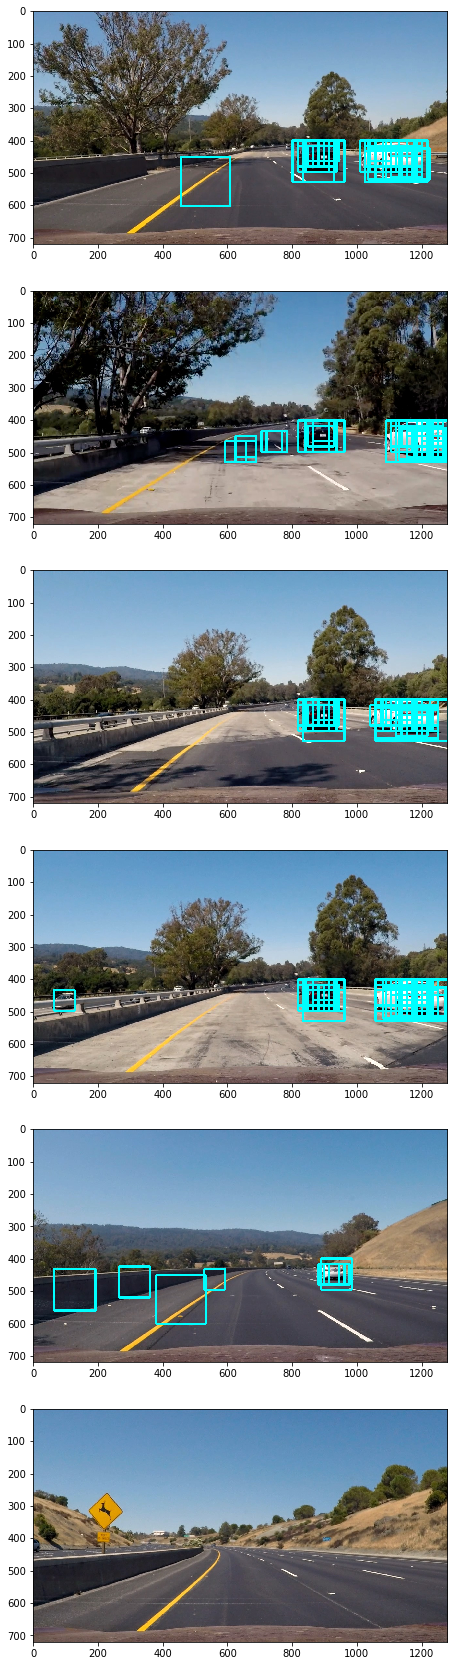

In [27]:
# Visualize the sliding window search.

%%time

fig, gs = figure(figsize=(12, 30), gssize=(6, 1))

for i, image in enumerate(test_images):
    windows = []
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(64, 64), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(96, 96), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 550), window_size=(128, 128), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(450, 600), window_size=(152, 152), overlap=(0.75, 0.75))
    
    hot_windows = find_cars(image, windows, clf, scaler, final_params)
    temp = draw_sliding_windows(image, hot_windows, color=(0, 255, 255))
    imshow(temp, gs[i], show_axis=True)

In [ ]:
# Not use this function.
def find_vehicles(image, y_start, y_stop, scale, classifier, scaler, params, window_size=64, cells_per_step=2):
    
    color_space = params['color_space']
    spatial_size = params['spatial_size']
    color_hist_bins = params['color_hist_bins']
    color_hist_channels = params['color_hist_channels']
    orient = params['hog_orientations']
    pix_per_cell = params['hog_pix_per_cell']
    cell_per_block = params['hog_cell_per_block']
    
    image_draw = np.copy(image)
    image = image.astype(np.float32) / float(np.max(image))
    
    image_roi = image[y_start:y_stop, :, :]
    image_roi = convert_color(image_roi, color_space)
    
    if scale != 1:
        roi_shape = image_roi.shape
        image_roi = cv2.resize(image_roi, (np.int(roi_shape[1] / scale), np.int(roi_shape[0] / scale)))
        
    ch0 = image_roi[:, :, 0]
    ch1 = image_roi[:, :, 1]
    ch2 = image_roi[:, :, 2]
    
    nxblocks = (image_roi.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (image_roi.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nblocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog0 = get_hog_features(ch0, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    result = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat0 = hog0[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack([hog_feat0, hog_feat1, hog_feat2])
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            sub_image = cv2.resize(image_roi[ytop:ytop+window_size, xleft:xleft+window_size], (64, 64))
            
            spatial_features = get_spatial_features(sub_image, size=spatial_size)
            
            color_features = []
            for ch in color_hist_channels:
                color_features.append(get_hist_features(image[:, :, ch], nbins=color_hist_bins))
            color_features = np.concatenate(color_features)
            
            test_features = scaler.transform(np.hstack([spatial_features, color_features, hog_features]).reshape(1, -1))
            test_pred = classifier.predict(test_features)
            conf = classifier.decision_function(test_features)
            
            if test_pred == 1 and conf > 0.8:
                scaled_xleft = np.int(xleft * scale)
                scaled_ytop = np.int(ytop * scale)
                scaled_window_size = np.int(window_size * scale)
                result.append((
                    (scaled_xleft, scaled_ytop+y_start),
                    (scaled_xleft+scaled_window_size, scaled_ytop+scaled_window_size+y_start)))      
    return result

In [ ]:
# Not use

%%time

fig, gs = figure(figsize=(12, 30), gssize=(6, 1))

for i, image in enumerate(test_images):
    windows = []
    windows += find_vehicles(image, 400, 530, scale=1.0, classifier=clf, scaler=scaler, params=final_params)
    windows += find_vehicles(image, 420, 600, scale=1.5, classifier=clf, scaler=scaler, params=final_params)
    windows += find_vehicles(image, 480, 650, scale=2.0, classifier=clf, scaler=scaler, params=final_params)
    windows += find_vehicles(image, 480, 680, scale=2.5, classifier=clf, scaler=scaler, params=final_params)
    
    temp = draw_sliding_windows(image, windows, color=(0, 255, 255))
    imshow(temp, gs[i], show_axis=True)

## Remove False Positives

In [28]:
def create_heatmap(windows, image_shape):
    """
    Creates heatmap based on hot windows.
    """
    heatmap = np.zeros(image_shape[:2])
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

In [29]:
def heatmap_threshold(heatmap, threshold):
    """
    Thresholds heatmap.
    """
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [30]:
def find_labeled_bboxes(heatmap, threshold):
    """
    Finds portions of the image to be recognized as vehicles.
    """
    heatmap = heatmap_threshold(heatmap, threshold)
    labels = label(heatmap)
    
    bboxes = []
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

In [60]:
class HeatmapBuffer:
    """
    Buffer to caches heatmaps to remove false positives across frames.
    """
    def __init__(self):
        self.max_length = 20
        self.buffer = None
        self.current = 0
        self.real_length = 0
        
    def avg_heatmap(self, heatmap):
        if self.buffer is None:
            self.buffer = np.zeros([self.max_length, heatmap.shape[0], heatmap.shape[1]], dtype=np.float64)
            
        self.buffer[self.current] = heatmap
        self.current += 1
        if self.current >= self.max_length: self.current = 0
        self.real_length += 1
        if self.real_length > self.max_length: self.real_length = self.max_length
        return np.average(self.buffer, axis=0), float(self.real_length / self.max_length)
    
    def sum_heatmap(self, heatmap):
        if self.buffer is None:
            self.buffer = np.zeros([self.max_length, heatmap.shape[0], heatmap.shape[1]], dtype=np.float64)
            
        self.buffer[self.current] = heatmap
        self.current += 1
        if self.current >= self.max_length: self.current = 0
        if self.real_length < self.max_length:self.real_length += 1
        threshold = self.real_length * 1.2 # 1.2 is a magic number, can be used to tune the heatmap threshold across frames.
        if threshold < 3: threshold = 3
        return np.sum(self.buffer, axis=0), threshold

In [61]:
def draw_labeled_bboxes(image, heatmap, heatmap_buffer):
    """
    Draws bounding boxes on image.
    """
    image_draw = np.copy(image)
    
    #avg_heatmap, avg_threshold = heatmap_buffer.avg_heatmap(heatmap)
    avg_heatmap, avg_threshold = heatmap_buffer.sum_heatmap(heatmap)
    bboxes = find_labeled_bboxes(avg_heatmap, avg_threshold)
    for bbox in bboxes:
        cv2.rectangle(image_draw, bbox[0], bbox[1], (0, 255, 255), 6)
    return image_draw

CPU times: user 22.9 s, sys: 1.1 s, total: 24 s
Wall time: 24.6 s


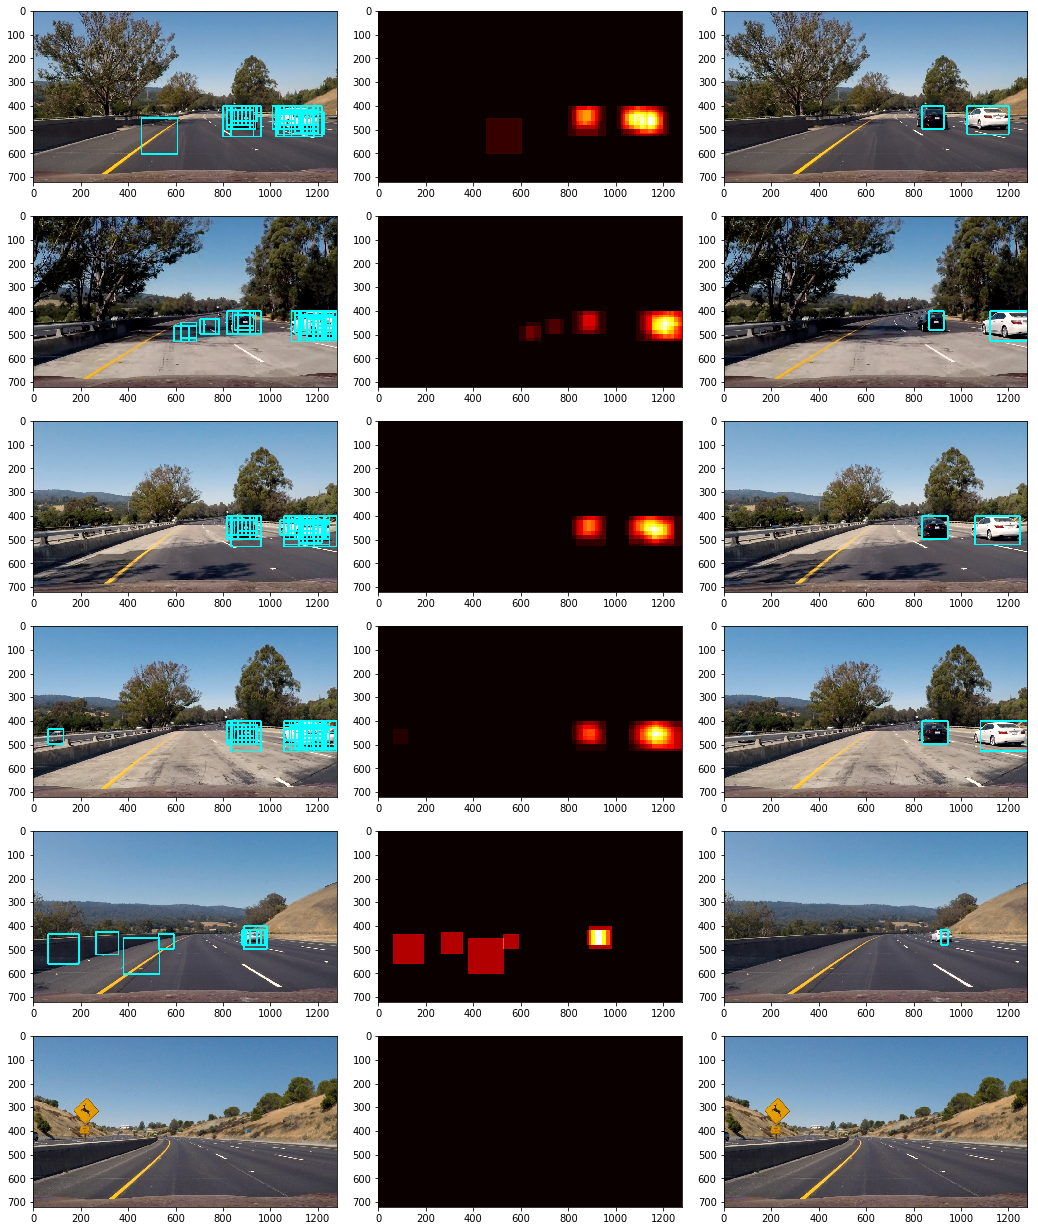

In [69]:
# Try to detect vehicles on test images.

%%time

fig, gs = figure(figsize=(18, 22), gssize=(6, 3))

for i, image in enumerate(test_images):
    windows = []
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(64, 64), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(96, 96), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 550), window_size=(128, 128), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(450, 600), window_size=(152, 152), overlap=(0.75, 0.75))
    
    hot_windows = find_cars(image, windows, clf, scaler, final_params)
    temp = draw_sliding_windows(image, hot_windows, color=(0, 255, 255))
    imshow(temp, gs[3*i], show_axis=True)
    
    heatmap = create_heatmap(hot_windows, image.shape)
    heatmap = heatmap_threshold(heatmap, 3)
    imshow(heatmap, gs[3*i+1], cmap='hot', show_axis=True)
    
    bbox = draw_labeled_bboxes(image, heatmap, HeatmapBuffer())
    imshow(bbox, gs[3*i+2], show_axis=True)

In [73]:
# The function to process video frame.

heatmap_buffer = HeatmapBuffer()

def process_frame(image):
    windows = []
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(64, 64), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 500), window_size=(96, 96), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(400, 550), window_size=(128, 128), overlap=(0.75, 0.75))
    windows += get_sliding_windows(image, y_range=(450, 600), window_size=(152, 152), overlap=(0.75, 0.75))
    
    hot_windows = find_cars(image, windows, clf, scaler, final_params)
    heatmap = create_heatmap(hot_windows, image.shape)
    heatmap = heatmap_threshold(heatmap, 3)
    result = draw_labeled_bboxes(image, heatmap, heatmap_buffer)
    
    return result

In [71]:
test_out_file = './test_video_out.mp4'
clip_test = VideoFileClip('./test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./test_video_out.mp4
[MoviePy] Writing video ./test_video_out.mp4


 97%|█████████▋| 38/39 [02:25<00:03,  3.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out.mp4 

CPU times: user 2min 21s, sys: 1.68 s, total: 2min 22s
Wall time: 2min 26s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [74]:
project_out_file = './project_video_out.mp4'
clip_project = VideoFileClip('./project_video.mp4')
clip_project_out = clip_project.fl_image(process_frame)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [1:14:36<00:03,  3.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 1h 12min 51s, sys: 36.8 s, total: 1h 13min 28s
Wall time: 1h 14min 37s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out_file))